In [1]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.text import *

In [25]:
df = pd.read_csv("/content/drive/My Drive/emotion.data")
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
df.head()

,id,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [5]:
train_df, valid_df = df.loc[:6075,:], df.loc[6075:,:]
len(train_df), len(valid_df)

(6076, 410734)

In [7]:
data_lm = TextLMDataBunch.from_df(Path("/content/drive/My Drive/data/train"), train_df, valid_df, text_cols=1, bs=32)
data_clas = TextClasDataBunch.from_df(Path("/content/drive/My Drive/data/train"), train_df, valid_df, text_cols=1, label_cols=2, bs=32)

In [8]:
data_lm.show_batch()

idx,text
0,few days back xxbos i xxunk that i am much more sensitive to other peoples feelings and tend to be more compassionate xxbos i find myself frustrated with christians because i feel that there is constantly a talk about loving one another being there for each other and praying for each other and i have seen that this is not always the case xxbos i am one of those people
1,xxbos i fear before each exam xxbos i sure do feel rich right now xxbos i really enjoy physics it makes me think and analyse and even though it gets frustrating the feeling of solving a problem is just wonderful xxbos i m quick to feel guilt for the innocent xxbos i was feeling confident once again xxunk and xxunk had succeeded in reminding me why i came here xxbos
2,for them xxbos i feel together a heartless beast subject book guest xxunk max online site xxunk those your fish in stay xxbos i remember feeling so helpless years ago holding that child in my arms xxunk waiting for his now grown brother and sister to get home from elementary school waiting to hear from friends and family in new xxunk city that all was ok xxbos i feel whiney
3,i feel like i xxunk ok for most of it xxbos i feel inspired to make some of the christmas xxunk i m giving away xxbos i feel like i ve been neglectful xxbos i feel this way why can t just be that girl that s happy with what she got in her life and lives in the moment not for the future xxbos i feel very horny i
4,because he wants to make the individual who speaks feel that what he has said is to me worthwhile worth understanding and that xxunk he is worthwhile for having said it xxbos i ve been going to school stuck in my tiny space facing my table xxunk with books feeling isolated xxbos i ve been feeling irritable since i xxunk the xxunk xxbos i really don t like this feeling


In [9]:
data_clas.show_batch()


text,target
xxbos i feel my heart becoming restless anxiety trying to get a hold of me every now and then i feel the tension taking over i m so distracted by everything but you say it s gon na be ok you are with me every step of the way i don t need to know where i m gon na go just as long as you lead the way,fear
xxbos i just want someone to sympathize with me that what i am feeling is ok and holy cow i am valid for feeling this way in some weird xxunk way by asking for sympathy i feel i am stealing sympathy from someone else who has it worse off lt holy amp t do you see how xxunk up and female i sound,joy
xxbos i wouldn t be sympathetic to her and i m sure i won t always feel the way i do now if we end up parenting him but for now i m mostly impressed by her strength and xxunk and sad that she still wasn t able to give her children the care they needed sad that she had to lose them,surprise
xxbos i feel vulnerable gt i get angry that i was made to feel vulnerable gt i get angry that i was made to feel angry gt i express my anger gt i feel ashamed that i am angry and expressed it gt i xxunk on what happened and xxunk my anger gt i feel exhausted from all the effort,fear
xxbos i mean its a good level on its own terms but everything before it was so well thought out and xxunk that doing constant mirror xxunk and xxunk it off with a crap final boss battle made the last level feel rushed in comparison though the last boss is bad no matter what way you xxunk it,anger


In [10]:
learn = language_model_learner(data_lm,AWD_LSTM,pretrained=True, drop_mult=0.3)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


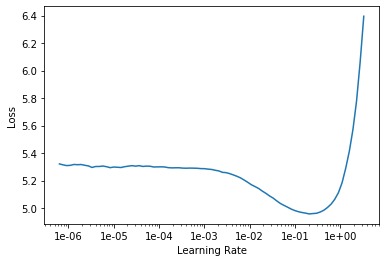

In [11]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.419816,3.964605,0.267593,01:36


In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


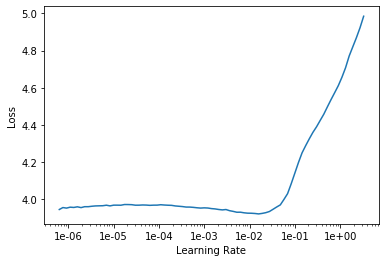

In [14]:
learn.lr_find()
learn.recorder.plot()

In [16]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,2.502155,4.129159,0.272232,01:35
1,2.506913,4.155303,0.269817,01:35
2,2.480550,4.242280,0.261092,01:35
3,2.333228,4.333220,0.261804,01:35
4,2.136676,4.437471,0.252935,01:35
5,1.940116,4.557300,0.252124,01:35
6,1.766316,4.649325,0.250786,01:35
7,1.648043,4.709142,0.248407,01:35
8,1.554689,4.734295,0.248586,01:35
9,1.501533,4.738163,0.247962,01:35


In [0]:
learn.save('lm')

In [0]:
learn.save_encoder('lm-enc')


In [19]:
learn = text_classifier_learner(data_clas,AWD_LSTM,pretrained=True ,drop_mult=0.3)
learn.load_encoder('lm-enc')



RNNLearner(data=TextClasDataBunch;

Train: LabelList (6076 items)
x: TextList
xxbos i feel awful about it too because it s my job to get him in a position to xxunk and it just didn t happen here,xxbos i m alone i feel awful,xxbos i ve probably mentioned this before but i really do feel proud of myself for actually keeping up with my new years xxunk of monthly and xxunk goals,xxbos i was feeling a little low few days back,xxbos i xxunk that i am much more sensitive to other peoples feelings and tend to be more compassionate
y: CategoryList
sadness,sadness,joy,sadness,love
Path: /content/drive/My Drive/data/train;

Valid: LabelList (410734 items)
x: TextList
xxbos i talk to her or hear from her i feel reassured,xxbos i remember going to xxunk the xxunk xxunk ground in the world located in xxunk western xxunk and feeling helpless because there were no xxunk there and i couldn t post my facebook status or xxunk about the xxunk xxunk,xxbos i am sexy young lady can xxunk all over you i feel 

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


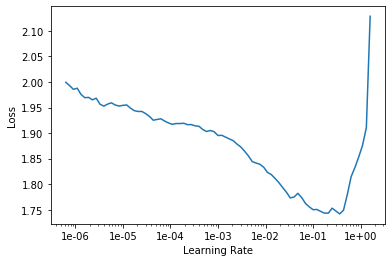

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.312017,1.229241,0.532133,02:05


In [22]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.053499,0.919950,0.661837,02:06
1,0.791077,0.744424,0.733409,02:05


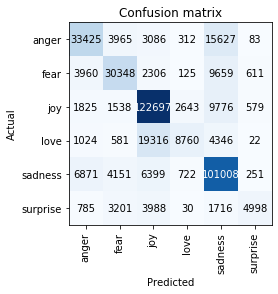

In [23]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)
interp.plot_confusion_matrix()

In [24]:
interp.most_confused()

[('love', 'joy', 19316),
 ('anger', 'sadness', 15627),
 ('joy', 'sadness', 9776),
 ('fear', 'sadness', 9659),
 ('sadness', 'anger', 6871),
 ('sadness', 'joy', 6399),
 ('love', 'sadness', 4346),
 ('sadness', 'fear', 4151),
 ('surprise', 'joy', 3988),
 ('anger', 'fear', 3965),
 ('fear', 'anger', 3960),
 ('surprise', 'fear', 3201),
 ('anger', 'joy', 3086),
 ('joy', 'love', 2643),
 ('fear', 'joy', 2306),
 ('joy', 'anger', 1825),
 ('surprise', 'sadness', 1716),
 ('joy', 'fear', 1538),
 ('love', 'anger', 1024),
 ('surprise', 'anger', 785),
 ('sadness', 'love', 722),
 ('fear', 'surprise', 611),
 ('love', 'fear', 581),
 ('joy', 'surprise', 579),
 ('anger', 'love', 312),
 ('sadness', 'surprise', 251),
 ('fear', 'love', 125),
 ('anger', 'surprise', 83),
 ('surprise', 'love', 30),
 ('love', 'surprise', 22)]